In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid, save_image
from torch.utils.data import ConcatDataset

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
# Transform each image by turning it into a tensor
MEAN_TRANSFORM = 0.5
STD_DEV_TRANSFORM = 0.5
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64

training_dataset = torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transforms)

testing_dataset = torchvision.datasets.MNIST(
    './data', train=False, transform=mnist_transforms)

data_set = torch.utils.data.ConcatDataset([training_dataset, testing_dataset])
TRAINLOADER = torch.utils.data.DataLoader(training_dataset,
                                          batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True)

https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [8]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [9]:
# learning parameters
batch_size = 512
epochs = 200
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
# print('##### GENERATOR #####')
# print(generator)
# print('######################')
# print('\n##### DISCRIMINATOR #####')
# print(discriminator)
# print('######################')

In [10]:
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
# loss function
criterion = nn.BCELoss()

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [12]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [12]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in enumerate(TRAINLOADER):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # # create the final fake image for the epoch
    # generated_img = generator(noise).cpu().detach()
    # # make the images as grid
    # generated_img = make_grid(generated_img)
    
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: 3.00447154, Discriminator loss: 0.75870377
Epoch 1 of 200
Generator loss: 5.27622986, Discriminator loss: 0.24038690
Epoch 2 of 200
Generator loss: 6.09234381, Discriminator loss: 0.15158498
Epoch 3 of 200
Generator loss: 6.47516441, Discriminator loss: 0.11240784
Epoch 4 of 200
Generator loss: 6.64123249, Discriminator loss: 0.08820368
Epoch 5 of 200
Generator loss: 6.42799473, Discriminator loss: 0.07980117
Epoch 6 of 200
Generator loss: 6.11336517, Discriminator loss: 0.08357561
Epoch 7 of 200
Generator loss: 6.18118763, Discriminator loss: 0.07223924
Epoch 8 of 200
Generator loss: 6.39418745, Discriminator loss: 0.05937028
Epoch 9 of 200
Generator loss: 6.57064438, Discriminator loss: 0.05451808
Epoch 10 of 200
Generator loss: 6.72000217, Discriminator loss: 0.04784749
Epoch 11 of 200
Generator loss: 6.83326197, Discriminator loss: 0.04267051
Epoch 12 of 200
Generator loss: 7.00517607, Discriminator loss: 0.04083306
Epoch 13 of 200
Generator loss: 7.0

KeyboardInterrupt: 

In [314]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

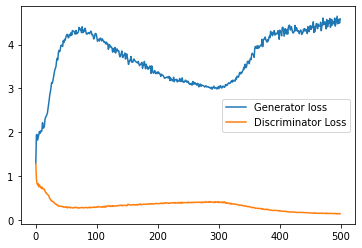

In [123]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
# plt.savefig('../outputs/loss.png')
plt.show()

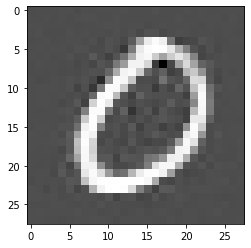

In [227]:
with torch.no_grad():
    results = generator(create_noise(1, nz)).cpu()
    plt.imshow(results[0].reshape((28, 28)), cmap='gray')
    plt.show()

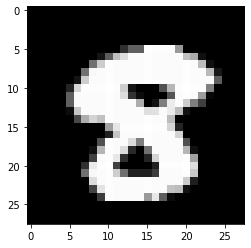

In [281]:
for data in TRAINLOADER:
    plt.imshow(data[0][0].reshape((28, 28)), cmap='gray')
    plt.show()
    break

# LSI

In [310]:
from ribs.archives import GridArchive
archive = GridArchive([50, 50], [(0, 784), (0, 1)], dtype=np.float32) # size and whiteness

In [311]:
from ribs.emitters import GaussianEmitter
from ribs.emitters import GaussianEmitter

img_size = (28, 28)
flat_img_size = 784  # 28 * 28
batch_size = 30
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(nz, 0.5),
        0.5,
        # Bound the generated images to the pixel range.
        bounds=[(0, 1)] * nz,
        batch_size=batch_size,
    )
]

In [312]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [313]:
total_itrs = 30_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask() # n_sol x sol_dim
    
    with torch.no_grad():
        generated_imgs = generator(torch.tensor(sols, 
            dtype=torch.float32).to(device)) # n_sol x 28 x 28
        objs = discriminator(generated_imgs).cpu().numpy()
        objs = objs.reshape(-1)

        generated_imgs = generated_imgs.cpu()\
                        .numpy().reshape((-1, flat_img_size))

        # normalize the values to [0, 1]
        normalized = (generated_imgs - np.min(generated_imgs))/ \
                     (np.max(generated_imgs) - np.min(generated_imgs))

        # the first bc is the "size" of the digit 
        # (i.e. number of white pixels)
        # we consider pixels with value larger than or equal to 0.7 as "white"
        digit_sizes = np.count_nonzero(
            normalized >= 0.7, axis=1).reshape(-1, 1) # n_sol x 1
        
        print(digit_sizes.shape)
        
        # the second bc is the "boldness" of the digit 
        # (i.e. how white white pixels are)
        # we use the mean value of the "white" pixels here
        normalized[normalized < 0.7] = 0 # zero out "non-white" pixels
        digit_boldness = np.divide(
            np.sum(normalized, axis=1), digit_sizes + 1) # n_sol x 1
        
        bcs = np.concatenate([digit_sizes, digit_boldness], axis=1)
    
    optimizer.tell(objs, bcs)
    
    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

(30, 1)
(30, 2)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float32, 2d, C), UniTuple(int32 x 2), array(float32, 1d, C))
 
There are 16 candidate implementations:
[1m    - Of which 16 did not match due to:
    Overload of function 'setitem': File: <numerous>: Line N/A.
      With argument(s): '(array(float32, 2d, C), UniTuple(int32 x 2), array(float32, 1d, C))':[0m
[1m     No match.[0m
[0m
[0m[1mDuring: typing of setitem at /home/lunjohnzhang/Desktop/coding/icaros/pyribs/ribs/archives/_archive_base.py (262)[0m
[1m
File "../../ribs/archives/_archive_base.py", line 262:[0m
[1m    def _add_numba(new_index, new_solution, new_objective_value,
        <source elided>
            # Insert into the archive.
[1m            objective_values[new_index] = new_objective_value
[0m            [1m^[0m[0m
